In [1]:
%matplotlib inline
%pylab inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from __future__ import division
from mhcflurry import predict
from mhcflurry import class1_allele_specific
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from modules.utils import coding, make_predictions

Populating the interactive namespace from numpy and matplotlib


Using Theano backend.
/home/vts/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
filepath = "./data/HIV_peptides.csv"
if os.path.isfile(filepath):
    df = pd.read_csv(filepath, sep=",")
    print("Reading {}".format(os.path.basename(filepath)))
else:
    print("File path is wrong")

Reading HIV_peptides.csv


In [3]:
df = df.dropna()
df = df.drop('Unnamed: 0', 1)
df.index = range(1,len(df) + 1)
print(len(df))
df.head(2)

1610


,binder,non_binder,mhc
1,GELDRWEKI,GELDRWkKI,B40
2,KIRLRPGGK,KIRLRPGGq,A3


In [4]:
df["non_binder"].iloc[0]

'GELDRWkKI'

In [5]:
#wdf = pd.DataFrame(columns=("Peptides", "MHC", "Binding"))
rows_list = []
for i in range(len(df)):
    dict1 = {}
    dict2 = {}
    dict1.update({'Peptide' : df['binder'].iloc[i], 'MHC' : df['mhc'].iloc[i], 'Binding' : 'Binder'})
    dict2.update({'Peptide' : df['non_binder'].iloc[i], 'MHC' : df['mhc'].iloc[i], 'Binding' : 'Non_binder'})
    rows_list.append(dict1)
    rows_list.append(dict2)
wdf = pd.DataFrame(rows_list)
print(len(wdf))
wdf['Peptide'] = wdf['Peptide'].str.upper()
wdf.head()

3220


,Binding,MHC,Peptide
0,Binder,B40,GELDRWEKI
1,Non_binder,B40,GELDRWKKI
2,Binder,A3,KIRLRPGGK
3,Non_binder,A3,KIRLRPGGQ
4,Binder,A3,KIRLRPGGK


In [6]:
print(unique(wdf['MHC']))

['A*01' 'A*0101' 'A*02' 'A*02, A*03' 'A*0201' 'A*0201, A*3002' 'A*0201, A2'
 'A*0202, A2' 'A*0205' 'A*0207' 'A*03' 'A*03, A*11' 'A*0301' 'A*0301, A*11'
 'A*0301, A*1101, A3, A*6801' 'A*0301, A*6801' 'A*11' 'A*1101' 'A*23'
 'A*23, A*2402, B*0801' 'A*23, A24' 'A*24' 'A*2402' 'A*2501' 'A*2601'
 'A*2601, A*2603' 'A*2603' 'A*2902' 'A*3002' 'A*31' 'A*3101' 'A*3201'
 'A*33' 'A*6801' 'A*6802' 'A1' 'A11' 'A11, A3' 'A2' 'A2, A3' 'A2, B62'
 'A2, B8' 'A2.1' 'A24' 'A24, B*5101' 'A24, B35' 'A25' 'A26' 'A26, B70'
 'A29' 'A3' 'A3 supertype, A*6801' 'A3, A30, B42, B62' 'A3, B7' 'A3, Cw3'
 'A30' 'A32, B14' 'A3?' 'B*07' 'B*0702' 'B*08' 'B*0801' 'B*13' 'B*1401'
 'B*1402' 'B*15' 'B*1501' 'B*1503' 'B*1510' 'B*1510, B70' 'B*1801' 'B*27'
 'B*2705' 'B*35' 'B*3501' 'B*37' 'B*3801' 'B*40' 'B*4001' 'B*4001, B50'
 'B*4201' 'B*4201, B*4202' 'B*4202' 'B*4402' 'B*4402, B*4403' 'B*4403'
 'B*4501' 'B*4801' 'B*51' 'B*5101' 'B*5401' 'B*57' 'B*57, B*58'
 'B*57, B*5801' 'B*5701' 'B*5701, B*5703' 'B*5701, B*58' 'B*5701, B*5

In [7]:
def f(row):
    if len(row['MHC']) == 6 and ',' not in row['MHC']:
        return 'HLA-{}'.format(row['MHC'])
#     if len(row['MHC']) == 4 and ',' not in row['MHC']:
#         return 'HLA-{}01'.format(row['MHC'])

wdf['MHC'] = wdf.apply(f, axis=1)

In [8]:
wdf = wdf.dropna()
wdf.head(5)

,Binding,MHC,Peptide
8,Binder,HLA-A*0301,KIRLRPGGK
9,Non_binder,HLA-A*0301,KIRLRPGGR
26,Binder,HLA-A*0301,RLRPGGKKK
27,Non_binder,HLA-A*0301,RLRPGGKKQ
42,Binder,HLA-A*0301,RLRPGGKKK


In [9]:
unique(wdf['MHC'])

array(['HLA-A*0101', 'HLA-A*0201', 'HLA-A*0205', 'HLA-A*0207',
       'HLA-A*0301', 'HLA-A*1101', 'HLA-A*2402', 'HLA-A*2501',
       'HLA-A*2601', 'HLA-A*2603', 'HLA-A*2902', 'HLA-A*3002',
       'HLA-A*3101', 'HLA-A*3201', 'HLA-A*6801', 'HLA-A*6802',
       'HLA-B*0702', 'HLA-B*0801', 'HLA-B*1401', 'HLA-B*1402',
       'HLA-B*1501', 'HLA-B*1503', 'HLA-B*1510', 'HLA-B*1801',
       'HLA-B*2705', 'HLA-B*3501', 'HLA-B*3801', 'HLA-B*4001',
       'HLA-B*4201', 'HLA-B*4202', 'HLA-B*4402', 'HLA-B*4403',
       'HLA-B*4501', 'HLA-B*4801', 'HLA-B*5101', 'HLA-B*5401',
       'HLA-B*5701', 'HLA-B*5703', 'HLA-B*5801', 'HLA-B*8101'], dtype=object)

In [10]:
wdf = wdf.drop_duplicates()
wdf['MHC'] = wdf['MHC'].str.replace('*', '')
wdf.head(10)

,Binding,MHC,Peptide
8,Binder,HLA-A0301,KIRLRPGGK
9,Non_binder,HLA-A0301,KIRLRPGGR
26,Binder,HLA-A0301,RLRPGGKKK
27,Non_binder,HLA-A0301,RLRPGGKKQ
43,Non_binder,HLA-A0301,RLRPGGRKK
58,Binder,HLA-B4201,RLRPGGKKHY
59,Non_binder,HLA-B4201,KLRPGGKKHY
61,Non_binder,HLA-B4201,RLRPGGKKRY
63,Non_binder,HLA-B4201,RLRPGGKKQY
92,Binder,HLA-B0801,GGKKKYKL


In [11]:
predictions, warning_loc = make_predictions(wdf);

Predictions made
Number of warnings is 44
                   0
Binding       Binder
MHC        HLA-B5703
Peptide  KAFSPEVIPMF
Binding   Non_binder
MHC        HLA-B5703
Peptide  KNFSPEVIPMF
Binding   Non_binder
MHC        HLA-B5703
Peptide  RAFSPEVIPMF
Binding       Binder
MHC        HLA-B4202
Peptide    TPQDLNMML
Binding   Non_binder
MHC        HLA-B4202
Peptide    TPQDLNTML
Binding       Binder
MHC        HLA-B8101
Peptide    TPQDLNTML
Binding   Non_binder
MHC        HLA-B8101
Peptide    TPEDLNTML
Binding   Non_binder
MHC        HLA-B8101
Peptide    TPQDLNMML
Binding   Non_binder
MHC        HLA-B8101
Peptide    TPQDLNAML
Binding   Non_binder
MHC        HLA-B8101
Peptide    TPADLNTML
...              ...
Binding       Binder
MHC        HLA-A0205
Peptide    RIRQGLERA
Binding   Non_binder
MHC        HLA-A0205
Peptide    RIRQGFERA
Binding   Non_binder
MHC        HLA-A0205
Peptide    RIRQGLEAA
Binding   Non_binder
MHC        HLA-A0205
Peptide    RIRQGLFRA
Binding       Binder
MHC        HL

In [12]:
predictions.head(5)

,Allele,Peptide,Prediction
0,HLA-A0301,KIRLRPGGK,44.690437
0,HLA-A0301,KIRLRPGGR,542.003174
0,HLA-A0301,RLRPGGKKK,26.093128
0,HLA-A0301,RLRPGGKKQ,1990.704102
0,HLA-A0301,RLRPGGRKK,47.910667


In [13]:
true_values = coding(wdf["Binding"], {"Binder":1, "Non_binder":0})
true_values = pd.DataFrame(true_values)
true_values.index = range(1,len(true_values) + 1)
true_values.drop(true_values.index[warning_loc], inplace=True)
true_values["Binding"].value_counts()

0    449
1    155
Name: Binding, dtype: int64

In [14]:
predicted_values = predictions["Prediction"]
predicted_values.index = range(1,len(predicted_values) + 1)
predicted_values.columns = ["Prediction"]
predicted_values = pd.DataFrame(predicted_values)
predicted_values["Prediction"] = np.where(predicted_values["Prediction"] <= 500, 1, 0)
predicted_values["Prediction"].value_counts()

1    361
0    243
Name: Prediction, dtype: int64

In [15]:
accuracy_score(true_values, predicted_values)

0.46688741721854304

In [16]:
roc_auc_score(true_values, predicted_values)

0.51891658883540481

In [17]:
confusion_matrix(true_values, predicted_values, labels=[0,1])

array([[185, 264],
       [ 58,  97]])

In [18]:
tn, fp, fn, tp = confusion_matrix(true_values, predicted_values, labels=[0,1]).ravel()
ln = len(true_values)
print(' true negative   {0:.2} \n \
false positive  {1:.2} \n \
false negative  {2:.2} \n \
true positive   {3:.2}'.format(tn/ln, fp/ln, fn/ln, tp/ln))

 true negative   0.31 
 false positive  0.44 
 false negative  0.096 
 true positive   0.16


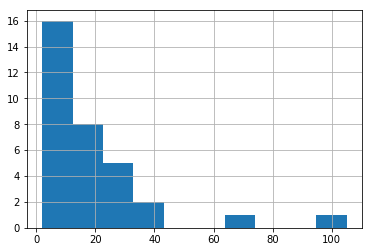

In [19]:
predictions.index = range(1,len(predictions) + 1)
predictions['Allele'].value_counts().hist()

In [20]:
wdf.index = range(1,len(wdf) + 1)
predictions['Binding'] = wdf['Binding']
predictions.head(5)

,Allele,Peptide,Prediction,Binding
1,HLA-A0301,KIRLRPGGK,44.690437,Binder
2,HLA-A0301,KIRLRPGGR,542.003174,Non_binder
3,HLA-A0301,RLRPGGKKK,26.093128,Binder
4,HLA-A0301,RLRPGGKKQ,1990.704102,Non_binder
5,HLA-A0301,RLRPGGRKK,47.910667,Non_binder


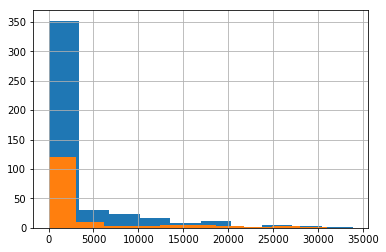

In [21]:
predictions[predictions['Binding'] == 'Non_binder']['Prediction'].hist()
predictions[predictions['Binding'] == 'Binder']['Prediction'].hist()
show()

In [22]:
predictions[predictions['Binding'] == 'Non_binder']['Prediction'].describe(), \
predictions[predictions['Binding'] == 'Binder']['Prediction'].describe()

(count      449.000000
 mean      2786.964426
 std       5609.838833
 min          1.765331
 25%         60.221264
 50%        238.945648
 75%       1763.565674
 max      33852.546875
 Name: Prediction, dtype: float64, count      155.000000
 mean      3198.328030
 std       6605.754669
 min          2.240298
 25%         60.961735
 50%        212.539337
 75%       1920.807190
 max      31023.105469
 Name: Prediction, dtype: float64)

In [23]:
b_list = []
nb_list = []
alleles = []
for allele in unique(predictions['Allele']):
    b_list.append(predictions[predictions['Allele'] == allele][predictions['Binding']=='Binder']['Prediction'].mean())
    nb_list.append(predictions[predictions['Allele'] == allele][predictions['Binding']=='Non_binder']['Prediction'].mean())
    alleles.append(allele)
tdf = pd.DataFrame({'Binder' : b_list, 'Non_binder' : nb_list})
tdf.index = alleles
tdf = tdf.dropna()
tdf

/home/vts/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/vts/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Binder,Non_binder
HLA-A0101,7712.343651,16426.972137
HLA-A0201,447.334083,1345.005417
HLA-A0301,166.857512,1378.233449
HLA-A1101,979.970254,1756.022771
HLA-A2402,5116.964351,2300.239229
HLA-A2501,15532.725427,10032.677700
HLA-A2603,5926.089071,3747.200307
HLA-A2902,16268.048340,4101.293345
HLA-A3002,10.063603,426.370066
HLA-A3101,2182.255350,5029.118079


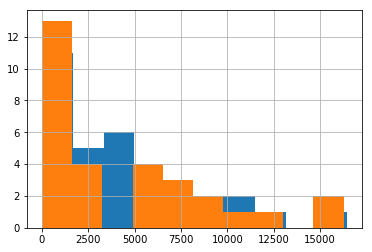

In [24]:
tdf['Non_binder'].hist()
tdf['Binder'].hist()
show()

In [25]:
tdf['Binder'].mean(), tdf['Non_binder'].mean()

(4307.220903901186, 4071.9234905137846)

In [26]:
tdf['Binder'].var(), tdf['Non_binder'].var()

(22532431.41998718, 16858817.72982233)

In [27]:
import scipy

scipy.stats.ttest_ind(tdf['Binder'], tdf['Non_binder'], equal_var=False)

Ttest_indResult(statistic=0.20534205492673502, pvalue=0.83803876318804904)

In [28]:
c = tdf[tdf['Binder'] <= 500]

scipy.stats.ttest_ind(c['Binder'], c['Non_binder'], equal_var=False)

Ttest_indResult(statistic=-2.2047663720255581, pvalue=0.06207270291943099)

In [39]:
from scipy.stats import normaltest
t_list = []
p_list = []
allele_list = []
for allele in unique(predictions['Allele']):
    a = predictions[predictions['Allele'] == allele][predictions['Binding']=='Binder']['Prediction']
    b = predictions[predictions['Allele'] == allele][predictions['Binding']=='Non_binder']['Prediction']
    a = np.log10(a)
    b = np.log10(b)
    c = scipy.stats.ttest_ind(a, b, equal_var=False)
    if len(a) >= 8:
        print(allele, 'pep', normaltest(a))
    if len(b) >= 8:
        print(allele, 'mut', normaltest(b))
    t_list.append(c[0])
    p_list.append(c[1])
    allele_list.append(allele)
stats_df = pd.DataFrame({'t_test': t_list,
                         'p_value': p_list,
                         'allele': allele_list})
stats_df.shape

('HLA-A0201', 'pep', NormaltestResult(statistic=3.0530839630508786, pvalue=0.21728574780262896))
('HLA-A0201', 'mut', NormaltestResult(statistic=6.8989063963415669, pvalue=0.031762999696823731))
('HLA-A0301', 'pep', NormaltestResult(statistic=2.0368092101768811, pvalue=0.36117069065834101))
('HLA-A0301', 'mut', NormaltestResult(statistic=3.3472208468032916, pvalue=0.18756863946748514))
('HLA-A1101', 'pep', NormaltestResult(statistic=0.63491503370655777, pvalue=0.72799760774655198))
('HLA-A1101', 'mut', NormaltestResult(statistic=2.789748636556753, pvalue=0.2478641864073689))
('HLA-A2402', 'mut', NormaltestResult(statistic=1.8545247004025103, pvalue=0.39563534014361479))
('HLA-A2501', 'mut', NormaltestResult(statistic=0.90070716994210187, pvalue=0.63740273574442274))
('HLA-A2603', 'mut', NormaltestResult(statistic=5.9033888847564517, pvalue=0.052251094427369041))
('HLA-A2902', 'mut', NormaltestResult(statistic=4.9231027983322599, pvalue=0.085302510016586133))
('HLA-B0702', 'pep', Normal

/home/vts/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/vts/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(33, 3)

In [30]:
stats_df = stats_df.dropna()
stats_df.shape

(24, 3)

In [37]:
stats_df[stats_df['p_value']>=0.05]

,allele,p_value,t_test
0,HLA-A0101,0.568742,-0.772940
1,HLA-A0201,0.317087,-1.007890
3,HLA-A1101,0.760968,0.308055
4,HLA-A2402,0.648405,0.484157
5,HLA-A2501,0.287612,1.126925
7,HLA-A2603,0.529409,0.726352
10,HLA-A3101,0.310533,-1.078447
12,HLA-A6801,0.568871,-0.647945
13,HLA-A6802,0.844196,-0.210585
14,HLA-B0702,0.699080,-0.395277


In [33]:
filepath = "./data/bdata.csv"
if os.path.isfile(filepath):
    bdf = pd.read_csv(filepath, sep=",")
    print("Reading {}".format(os.path.basename(filepath)))
else:
    print("File path is wrong")

Reading bdata.csv


In [41]:
bdf.head()

,species,mhc,peptide_length,cv,sequence,inequality,meas
0,cow,BoLAHD6,9,TBD,ALFYKDGKL,=,1.000000
1,cow,BoLAHD6,9,TBD,ALYEKKLAL,=,1.000000
2,cow,BoLAHD6,9,TBD,AMKDRFQPL,=,4.521706
3,cow,BoLAHD6,9,TBD,AQRELFFTL,=,1.000000
4,cow,BoLAHD6,9,TBD,FMKVKFEAL,=,1.576747


In [34]:
bdf[bdf.species == 'human']['mhc'].value_counts()

HLAA0201    11920
HLAA0301     7089
HLAA0203     6302
HLAA1101     6255
HLAA3101     5628
HLAA0206     5627
HLAA6802     5545
HLAA0101     4558
HLAB0702     4379
HLAA2601     4326
HLAA0202     4155
HLAB1501     4135
HLAA6801     3795
HLAA3301     3597
HLAB2705     3443
HLAB0801     3326
HLAA2402     3230
HLAB4001     3226
HLAB5801     3121
HLAB3501     3060
HLAA3001     2778
HLAB5701     2776
HLAB1801     2705
HLAB5101     2691
HLAA2902     2658
HLAA6901     2564
HLAA2301     2508
HLAB4402     2205
HLAA3002     1927
HLAB4601     1803
            ...  
HLAB5703       34
HLAA0319       30
HLAA0302       26
HLAB8101       26
HLAA0210       18
HLAB4202       18
HLAB5702       18
HLAB5201       15
HLAA1102       14
HLAA7401        9
HLAB2702        8
HLAB2706        7
HLAA3           6
HLAB44          5
HLAB60          5
HLAA0204        4
HLAB2704        4
HLACw1          4
HLAA26          4
HLAB2701        4
HLAB51          3
HLAB27          2
HLACw4          2
HLAB2710        2
HLAA3/11  

In [40]:
stats_df.allele = stats_df.allele.str.replace('-', '')
stats_df.head()

,allele,p_value,t_test
0,HLAA0101,0.568742,-0.772940
1,HLAA0201,0.317087,-1.007890
2,HLAA0301,0.009546,-2.828402
3,HLAA1101,0.760968,0.308055
4,HLAA2402,0.648405,0.484157


In [44]:
count_list = []
for allele in stats_df.allele:
    count_list.append(len(bdf[bdf['mhc']==allele]))

top_hla = pd.DataFrame({'allele': stats_df.allele,
                        'counts': count_list})
top_hla.head()

,allele,counts
0,HLAA0101,4558
1,HLAA0201,11920
2,HLAA0301,7089
3,HLAA1101,6255
4,HLAA2402,3230


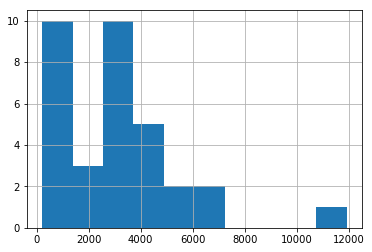

In [45]:
top_hla.counts.hist()

In [46]:
top_hla.counts.min()

203